In [1]:
import os, random

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth=True

sess = tf.Session(config=config)

import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import Audio
from matplotlib.pyplot import imshow
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.contrib.keras import layers
from tensorflow.contrib.keras import models
from tensorflow.contrib.keras import layers
from tensorflow.contrib.keras import optimizers
from tensorflow.contrib.keras import callbacks
from tensorflow.contrib.keras import regularizers
from tensorflow.contrib.keras import models

%matplotlib inline

/home/jonas/audioset-role/.venv/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())
print(device_lib.list_local_devices())

['/device:CPU:0', '/device:GPU:0']
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4843414185093630697
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 146538496
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7789384309945932260
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [3]:
PNG_DIR = 'spectrogram_images/'
IMG_DIR = 'spectrogram_jpg/'
IMG_HEIGHT = 216
IMG_WIDTH = 216
NUM_CLASSES = 10
NUM_EPOCHS = 10
BATCH_SIZE = 32
L2_LAMBDA = 0.001

In [4]:
# Randomly select 1 spectrogram from each category for plotting
sample_files = []
for i in range(7):
    sample_files.append(random.choice(os.listdir(IMG_DIR)))
    
label_dict = {  'Background_music':0,
                'Theme_music':1,
                'Jingle':2,
                'Soundtrack_music':3,
                'Lullaby':4,
                'Video_game_music':5,
                'Christmas_music':6,
                'Dance_music':7,
                'Wedding_music':8,
                'Birthday_music':9} 

one_hot = OneHotEncoder(n_values=NUM_CLASSES)

all_files = os.listdir(IMG_DIR)

# Get class weights
label_array = []
for file_ in all_files:
    vals = file_[:-4].split('_', 1)[1]
    label_array.append(label_dict[vals])
    
cl_weight = compute_class_weight(class_weight = 'balanced', 
                                 classes = np.unique(label_array), 
                                 y = label_array)

# Train-val-test split of files
train_files, test_files, train_labels, test_labels = train_test_split(all_files, 
                                                                      label_array,
                                                                      random_state = 10, 
                                                                      test_size = 0.1
                                                                     )

# Among the test files, keep half for validation
val_files, test_files, val_labels, test_labels = train_test_split(test_files, test_labels,
                                                                  random_state = 10, 
                                                                  test_size = 0.5
                                                                 )

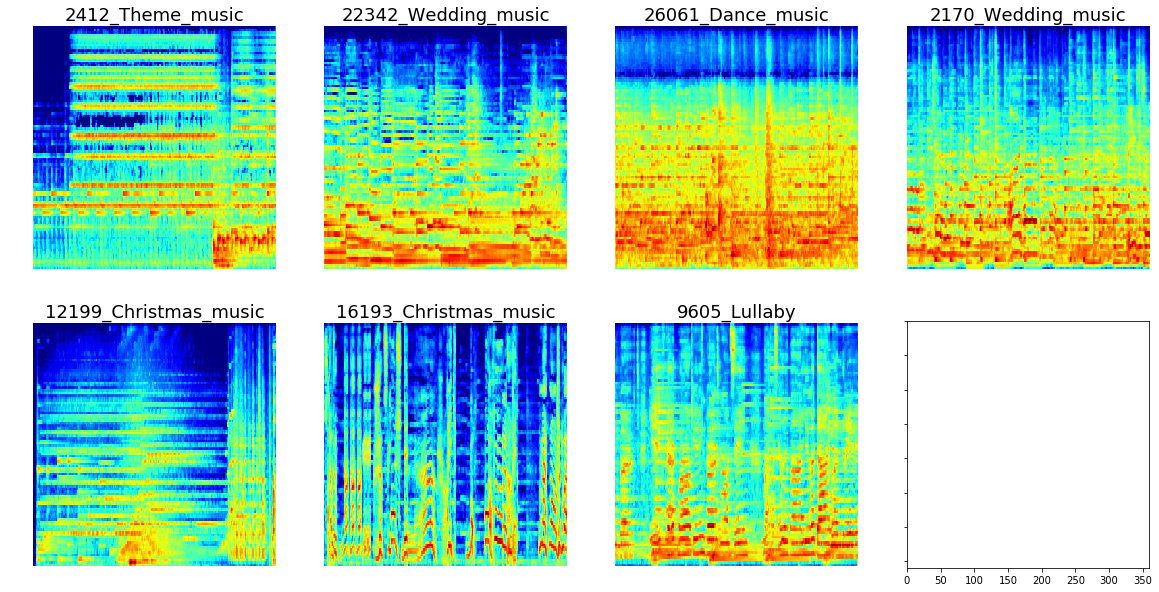

In [5]:
f, axarr = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(20,10))
coordinates = [(0,0),(0,1),(0,2),(0,3), 
               (1,0),(1,1),(1,2) ]

for i, file_ in enumerate(sample_files):
    im = Image.open(IMG_DIR + file_)
    # im = im.resize((IMG_WIDTH, IMG_HEIGHT), resample = Image.ANTIALIAS)
    axarr[coordinates[i]].imshow(np.asarray(im))
    axarr[coordinates[i]].axis('off')
    axarr[coordinates[i]].set_title(file_[:-4], fontsize=18)


Samples above show that the spectrograms are different for different genres.

In [6]:
conv_base = tf.contrib.keras.applications.VGG16(include_top = False, 
                                            weights = 'imagenet', 
                                            input_shape = (IMG_WIDTH, IMG_HEIGHT, 3) # 3 channels - RGB
                                           ) 
# The weights are for the CONV filters - hence you can pass any pre-set image size to this VGG network
# Need not be 224 x 224 x 3 (Although does it work better for 224 size? Need to check)

In [7]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 216, 216, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 216, 216, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 216, 216, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 108, 108, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 108, 108, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 108, 108, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 54, 54, 128)       0         
__________

In [8]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten()) # Flatten output and send it to MLP

model.add(layers.Dense(512, name='dense_1', kernel_regularizer=regularizers.l2(L2_LAMBDA)))
model.add(layers.Dropout(rate=0.3, name='dropout_1')) # Can try varying dropout rates
model.add(layers.Activation(activation='relu', name='activation_1'))

model.add(layers.Dense(NUM_CLASSES, activation='softmax', name='dense_output'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 6, 6, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               9437696   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_output (Dense)         (None, 10)                5130      
Total params: 24,157,514
Trainable params: 24,157,514
Non-trainable params: 0
________________________________________________________________

In [9]:
# Set the convolution base to be trainable
conv_base.trainable = True
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 6, 6, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               9437696   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_output (Dense)         (None, 10)                5130      
Total params: 24,157,514
Trainable params: 24,157,514
Non-trainable params: 0
________________________________________________________________

In [12]:
# Load the transfer learning model and use its dense network to initialize the weights of the fine-tune model
tl_model = models.load_model(filepath='saved_models/transfer_learning_epoch_10_0.3789.h5') # 02 is epoch 3
tl_model.weights[-4:] # The weights from the 2 dense layers have to be transferred to the new model

ResourceExhaustedError: OOM when allocating tensor with shape[3,3,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: block4_conv2_3/kernel/Initializer/random_uniform/RandomUniform = RandomUniform[T=DT_INT32, _class=["loc:@block4_conv2_3/kernel/Assign"], dtype=DT_FLOAT, seed=0, seed2=0, _device="/job:localhost/replica:0/task:0/device:GPU:0"](block4_conv2_3/kernel/Initializer/random_uniform/shape)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'block4_conv2_3/kernel/Initializer/random_uniform/RandomUniform', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jonas/audioset-role/.venv/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/jonas/audioset-role/.venv/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jonas/audioset-role/.venv/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/jonas/audioset-role/.venv/lib/python3.5/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 345, in run_forever
    self._run_once()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 1312, in _run_once
    handle._run()
  File "/usr/lib/python3.5/asyncio/events.py", line 125, in _run
    self._callback(*self._args)
  File "/home/jonas/audioset-role/.venv/lib/python3.5/site-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/home/jonas/audioset-role/.venv/lib/python3.5/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/jonas/audioset-role/.venv/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/jonas/audioset-role/.venv/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/jonas/audioset-role/.venv/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/jonas/audioset-role/.venv/lib/python3.5/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/jonas/audioset-role/.venv/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/jonas/audioset-role/.venv/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/jonas/audioset-role/.venv/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/jonas/audioset-role/.venv/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/jonas/audioset-role/.venv/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/jonas/audioset-role/.venv/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/jonas/audioset-role/.venv/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/jonas/audioset-role/.venv/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/jonas/audioset-role/.venv/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-13f33926b30f>", line 2, in <module>
    tl_model = models.load_model(filepath='saved_models/transfer_learning_epoch_10_0.3789.h5') # 02 is epoch 3
  File "/home/jonas/audioset-role/.venv/lib/python3.5/site-packages/tensorflow/python/keras/_impl/keras/engine/saving.py", line 241, in load_model
    model = model_from_config(model_config, custom_objects=custom_objects)
  File "/home/jonas/audioset-role/.venv/lib/python3.5/site-packages/tensorflow/python/keras/_impl/keras/engine/saving.py", line 318, in model_from_config
    return deserialize(config, custom_objects=custom_objects)
  File "/home/jonas/audioset-role/.venv/lib/python3.5/site-packages/tensorflow/python/keras/_impl/keras/layers/serialization.py", line 63, in deserialize
    printable_module_name='layer')
  File "/home/jonas/audioset-role/.venv/lib/python3.5/site-packages/tensorflow/python/keras/_impl/keras/utils/generic_utils.py", line 171, in deserialize_keras_object
    list(custom_objects.items())))
  File "/home/jonas/audioset-role/.venv/lib/python3.5/site-packages/tensorflow/python/keras/_impl/keras/engine/sequential.py", line 316, in from_config
    layer = layer_module.deserialize(conf, custom_objects=custom_objects)
  File "/home/jonas/audioset-role/.venv/lib/python3.5/site-packages/tensorflow/python/keras/_impl/keras/layers/serialization.py", line 63, in deserialize
    printable_module_name='layer')
  File "/home/jonas/audioset-role/.venv/lib/python3.5/site-packages/tensorflow/python/keras/_impl/keras/utils/generic_utils.py", line 171, in deserialize_keras_object
    list(custom_objects.items())))
  File "/home/jonas/audioset-role/.venv/lib/python3.5/site-packages/tensorflow/python/keras/_impl/keras/engine/network.py", line 1067, in from_config
    process_node(layer, node_data)
  File "/home/jonas/audioset-role/.venv/lib/python3.5/site-packages/tensorflow/python/keras/_impl/keras/engine/network.py", line 1025, in process_node
    layer(input_tensors[0], **kwargs)
  File "/home/jonas/audioset-role/.venv/lib/python3.5/site-packages/tensorflow/python/keras/_impl/keras/engine/base_layer.py", line 314, in __call__
    output = super(Layer, self).__call__(inputs, *args, **kwargs)
  File "/home/jonas/audioset-role/.venv/lib/python3.5/site-packages/tensorflow/python/layers/base.py", line 699, in __call__
    self.build(input_shapes)
  File "/home/jonas/audioset-role/.venv/lib/python3.5/site-packages/tensorflow/python/layers/convolutional.py", line 144, in build
    dtype=self.dtype)
  File "/home/jonas/audioset-role/.venv/lib/python3.5/site-packages/tensorflow/python/layers/base.py", line 546, in add_variable
    partitioner=partitioner)
  File "/home/jonas/audioset-role/.venv/lib/python3.5/site-packages/tensorflow/python/training/checkpointable.py", line 436, in _add_variable_with_custom_getter
    **kwargs_for_getter)
  File "/home/jonas/audioset-role/.venv/lib/python3.5/site-packages/tensorflow/python/ops/variable_scope.py", line 1317, in get_variable
    constraint=constraint)
  File "/home/jonas/audioset-role/.venv/lib/python3.5/site-packages/tensorflow/python/ops/variable_scope.py", line 1079, in get_variable
    constraint=constraint)
  File "/home/jonas/audioset-role/.venv/lib/python3.5/site-packages/tensorflow/python/ops/variable_scope.py", line 425, in get_variable
    constraint=constraint)
  File "/home/jonas/audioset-role/.venv/lib/python3.5/site-packages/tensorflow/python/ops/variable_scope.py", line 394, in _true_getter
    use_resource=use_resource, constraint=constraint)
  File "/home/jonas/audioset-role/.venv/lib/python3.5/site-packages/tensorflow/python/ops/variable_scope.py", line 786, in _get_single_variable
    use_resource=use_resource)
  File "/home/jonas/audioset-role/.venv/lib/python3.5/site-packages/tensorflow/python/ops/variable_scope.py", line 2220, in variable
    use_resource=use_resource)
  File "/home/jonas/audioset-role/.venv/lib/python3.5/site-packages/tensorflow/python/ops/variable_scope.py", line 2210, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "/home/jonas/audioset-role/.venv/lib/python3.5/site-packages/tensorflow/python/ops/variable_scope.py", line 2193, in default_variable_creator
    constraint=constraint)
  File "/home/jonas/audioset-role/.venv/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 235, in __init__
    constraint=constraint)
  File "/home/jonas/audioset-role/.venv/lib/python3.5/site-packages/tensorflow/python/ops/variables.py", line 343, in _init_from_args
    initial_value(), name="initial_value", dtype=dtype)
  File "/home/jonas/audioset-role/.venv/lib/python3.5/site-packages/tensorflow/python/ops/variable_scope.py", line 770, in <lambda>
    shape.as_list(), dtype=dtype, partition_info=partition_info)
  File "/home/jonas/audioset-role/.venv/lib/python3.5/site-packages/tensorflow/python/ops/init_ops.py", line 472, in __call__
    shape, -limit, limit, dtype, seed=self.seed)
  File "/home/jonas/audioset-role/.venv/lib/python3.5/site-packages/tensorflow/python/ops/random_ops.py", line 242, in random_uniform
    rnd = gen_random_ops.random_uniform(shape, dtype, seed=seed1, seed2=seed2)
  File "/home/jonas/audioset-role/.venv/lib/python3.5/site-packages/tensorflow/python/ops/gen_random_ops.py", line 674, in random_uniform
    name=name)
  File "/home/jonas/audioset-role/.venv/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/jonas/audioset-role/.venv/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/home/jonas/audioset-role/.venv/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[3,3,512,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: block4_conv2_3/kernel/Initializer/random_uniform/RandomUniform = RandomUniform[T=DT_INT32, _class=["loc:@block4_conv2_3/kernel/Assign"], dtype=DT_FLOAT, seed=0, seed2=0, _device="/job:localhost/replica:0/task:0/device:GPU:0"](block4_conv2_3/kernel/Initializer/random_uniform/shape)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [ ]:
for i in range(1, len(model.layers)): # The first layer (index = 0) is the conv base
    model.layers[i].set_weights(tl_model.layers[i].get_weights())

In [ ]:
def load_batch(file_list):
    img_array = []
    idx_array = []
    label_array = []

    for file_ in file_list:
        im = Image.open(IMG_DIR + file_)
        im = im.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)
        img_array.append(np.array(im))

        vals = file_[:-4].split('_', 1)
        idx_array.append(vals[0])
        label_array.append([label_dict[vals[1]]])

    label_array = one_hot.fit_transform(label_array).toarray()
    img_array = np.array(img_array)/255.0 # Normalize RGB
    
    return img_array, np.array(label_array), np.array(idx_array)

In [ ]:
def batch_generator(files, BATCH_SIZE):
    L = len(files)

    #this line is just to make the generator infinite, keras needs that    
    while True:

        batch_start = 0
        batch_end = BATCH_SIZE

        while batch_start < L:
            
            limit = min(batch_end, L)
            file_list = files[batch_start: limit]
            batch_img_array, batch_label_array, batch_idx_array = load_batch(file_list)

            yield (batch_img_array, batch_label_array) # a tuple with two numpy arrays with batch_size samples     

            batch_start += BATCH_SIZE   
            batch_end += BATCH_SIZE

In [ ]:
# Set optimizer, loss and metrics
optimizer = optimizers.Adam(lr=1e-5)

loss = 'categorical_crossentropy'

metrics = ['categorical_accuracy']

filepath="saved_models/fine_tuning_epoch_{epoch:02d}_{val_categorical_accuracy:.4f}.h5"
checkpoint = callbacks.ModelCheckpoint(filepath, 
                                       monitor='val_categorical_accuracy', 
                                       verbose=0, 
                                       save_best_only=False)
callbacks_list = [checkpoint]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [29]:
STEPS_PER_EPOCH = len(train_files)//BATCH_SIZE
VAL_STEPS = len(val_files)//BATCH_SIZE

history = model.fit_generator(generator  = batch_generator(train_files, BATCH_SIZE),
                              epochs     = NUM_EPOCHS,
                              steps_per_epoch = STEPS_PER_EPOCH,
                              class_weight = cl_weight, # Check if providing class weight is useful
                              validation_data = batch_generator(val_files, BATCH_SIZE), 
                              validation_steps = VAL_STEPS, 
                              callbacks = callbacks_list,
                             )

Epoch 1/10
  2/144 [..............................] - ETA: 1:50:36 - loss: 2.1557 - categorical_accuracy: 0.4688

KeyboardInterrupt: 

In [13]:
# Save scores on train and validation sets
with open('pickle_files/fine_tuning_no_initialization_vgg16_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

#### Determine the best performing model

In [14]:
# Load scores
with open('pickle_files/fine_tuning_no_initialization_vgg16_history.pkl', 'rb') as f:
    scores = pickle.load(f)
print(scores.keys())
scores = pd.DataFrame(scores, index=range(1,11))

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy'])


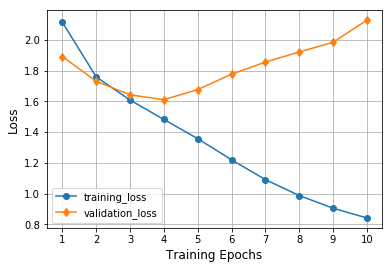

In [15]:
plt.xticks(range(1,11))
plt.plot(scores['loss'], marker='o', label='training_loss')
plt.plot(scores['val_loss'], marker='d', label='validation_loss')
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Training Epochs', fontsize=12)
plt.grid()
plt.legend()
plt.savefig('plots/learning-curve-loss.png')

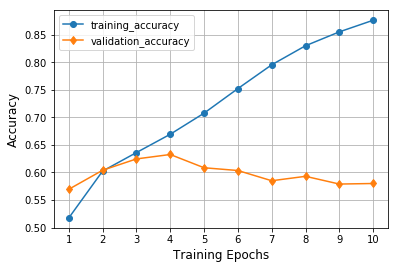

In [16]:
plt.xticks(range(1,11))
plt.plot(scores['categorical_accuracy'], marker='o', label='training_accuracy')
plt.plot(scores['val_categorical_accuracy'], marker='d', label='validation_accuracy')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Training Epochs', fontsize=12)
plt.grid()
plt.legend()
plt.savefig('plots/learning-curve-accuracy.png')

Choose epoch 4 to be the model that does well on the validation set (in terms of minimum loss and maximum accuracy).

In [17]:
model = models.load_model(filepath='saved_models/fine_tuning_epoch_03_0.6326.h5') # 03 is epoch 4

In [18]:
# Make Prediction on Test set
TEST_STEPS = len(test_files)//BATCH_SIZE
pred_probs = model.predict_generator(generator = batch_generator(test_files, BATCH_SIZE), 
                                     steps=TEST_STEPS)
pred = np.argmax(pred_probs, axis=-1)

In [29]:
with open('pred_probas/testset_filenames.txt', 'w') as f:
    f.write('\n'.join([t.split('.')[0]+'.wav' for t in test_files]))

In [31]:
with open('pred_probas/vgg_fine_tuning.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

### Evaluation of the best performing model

In [19]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score, roc_curve, auc
from scipy import interp
import itertools
from itertools import cycle
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

Confusion matrix, without normalization
[[232  56   2  27  16  10  19]
 [ 35 224   8  26  11  47  30]
 [  8  22 110   0   3  17   9]
 [ 34  59   1  77  14  31  16]
 [ 29  20   3   3  65   8   4]
 [  6  38   6   6   4 339  14]
 [ 15  30  10   5   9  21 237]]


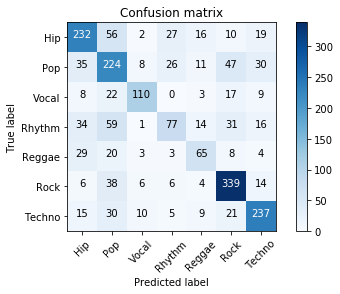

In [20]:
plot_confusion_matrix(confusion_matrix(y_true=test_labels[:len(pred)], y_pred=pred), 
                      classes=label_dict.keys())

In [21]:
print('Test Set Accuracy =  {0:.2f}'.format(accuracy_score(y_true=test_labels[:len(pred)], y_pred=pred)))
print('Test Set F-score =  {0:.2f}'.format(f1_score(y_true=test_labels[:len(pred)], y_pred=pred, average='macro')))

Test Set Accuracy =  0.64
Test Set F-score =  0.61


In [22]:
one_hot_true = one_hot_encoder(test_labels, len(pred), len(label_dict))
print('ROC AUC = {0:.3f}'.format(roc_auc_score(y_true=one_hot_true, y_score=pred_probs, average='macro')))

ROC AUC = 0.889


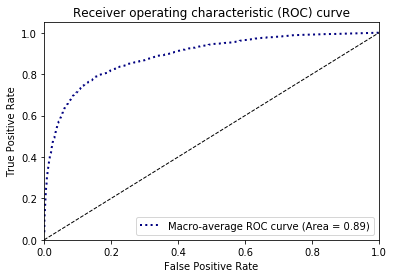

In [23]:
# Compute macro-average ROC curve and ROC area
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(one_hot_true[:, i], pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])    

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(NUM_CLASSES)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(NUM_CLASSES):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= NUM_CLASSES

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["macro"], tpr["macro"],
         label='Macro-average ROC curve (Area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()